In [3]:
import pandas as pd
import numpy as np
# Load cleaned dataset
df = pd.read_csv("drugs.csv")

# Show basic info
print(df.shape)
print(df.columns)
print(df.head())


(2931, 17)
Index(['drug_name', 'medical_condition', 'side_effects', 'generic_name',
       'drug_classes', 'brand_names', 'activity', 'rx_otc',
       'pregnancy_category', 'csa', 'alcohol', 'related_drugs',
       'medical_condition_description', 'rating', 'no_of_reviews', 'drug_link',
       'medical_condition_url'],
      dtype='object')
        drug_name medical_condition  \
0     doxycycline              Acne   
1  spironolactone              Acne   
2     minocycline              Acne   
3        Accutane              Acne   
4     clindamycin              Acne   

                                        side_effects         generic_name  \
0  (hives, difficult breathing, swelling in your ...          doxycycline   
1  hives ; difficulty breathing; swelling of your...       spironolactone   
2  skin rash, fever, swollen glands, flu-like sym...          minocycline   
3  problems with your vision or hearing; muscle o...  isotretinoin (oral)   
4  hives ; difficult breathing; swell

In [4]:
def recommend_popular(df, condition, top_k=5):
    # filter by medical condition
    cond_df = df[df["medical_condition"].str.lower() == condition.lower()]
    
    # compute popularity score = rating * log(no_of_reviews+1)
    cond_df = cond_df.copy()
    cond_df["popularity_score"] = cond_df["rating"] * np.log1p(cond_df["no_of_reviews"])
    
    # sort by popularity
    top_drugs = cond_df.sort_values("popularity_score", ascending=False).head(top_k)
    return top_drugs[["drug_name", "rating", "no_of_reviews", "popularity_score"]]

# Example usage:
print(recommend_popular(df, "Acne", top_k=5))


                         drug_name  rating  no_of_reviews  popularity_score
7                     isotretinoin     8.0          999.0         55.262042
3                         Accutane     7.9          623.0         50.845588
47    adapalene / benzoyl peroxide     7.3          909.0         49.738146
23  benzoyl peroxide / clindamycin     7.6          570.0         48.240158
13                          Epiduo     7.3          698.0         47.812450


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def build_content_model(df):
    # combine useful text columns
    df["combined_text"] = (
        df["side_effects"].fillna("") + " " +
        df["drug_classes"].fillna("") + " " +
        df["medical_condition_description"].fillna("")
    )
    
    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(df["combined_text"])
    
    # compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    return cosine_sim

# Build similarity matrix
cosine_sim = build_content_model(df)

def recommend_similar(drug_name, df, cosine_sim, top_k=5):
    # drug index
    indices = pd.Series(df.index, index=df["drug_name"].str.lower())
    
    if drug_name.lower() not in indices:
        return f"{drug_name} not found!"
    
    idx = indices[drug_name.lower()]
    
    # similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # top-k most similar (skip itself at index 0)
    sim_indices = [i for i, _ in sim_scores[1:top_k+1]]
    
    return df.iloc[sim_indices][["drug_name", "medical_condition", "rating", "no_of_reviews"]]

# Example usage:
print(recommend_similar("Accutane", df, cosine_sim, top_k=5))



        drug_name medical_condition  rating  no_of_reviews
42       Claravis              Acne     8.2          116.0
59      Amnesteem              Acne     7.8           27.0
68       Myorisan              Acne     8.7           10.0
103        Sotret              Acne     8.0            3.0
7    isotretinoin              Acne     8.0          999.0


In [7]:
print(df.shape)                # rows x columns
print(df.info())               # column types + non-null counts
print(df.isna().sum())         # missing values per column
print(df.duplicated().sum())   # number of duplicate rows
print(df.describe(include="all"))  # summary of numeric & categorical columns



(2931, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 n

In [8]:
df.isnull().sum

<bound method DataFrame.sum of       drug_name  medical_condition  side_effects  generic_name  drug_classes  \
0         False              False         False         False         False   
1         False              False         False         False         False   
2         False              False         False         False         False   
3         False              False         False         False         False   
4         False              False         False         False         False   
...         ...                ...           ...           ...           ...   
2926      False              False         False         False         False   
2927      False              False         False         False         False   
2928      False              False          True         False         False   
2929      False              False         False         False         False   
2930      False              False         False         False         False   

      br

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

In [10]:
df['side_effects'] = df['side_effects'].fillna("Not available")
df['generic_name'] = df['generic_name'].fillna("Unknown")
df['drug_classes'] = df['drug_classes'].fillna("Unknown")
df['brand_names'] = df['brand_names'].fillna("Unknown")
df['rx_otc'] = df['rx_otc'].fillna("Unknown")
df['pregnancy_category'] = df['pregnancy_category'].fillna("Unknown")


In [11]:
df['rating'] = df['rating'].fillna(df['rating'].median())
df['no_of_reviews'] = df['no_of_reviews'].fillna(0)


In [12]:
# Convert activity "87%" -> 87
df['activity'] = df['activity'].str.replace('%', '', regex=False).astype(float)


In [13]:
df.drop(columns=['drug_link', 'medical_condition_url'], inplace=True)


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2931 non-null   object 
 3   generic_name                   2931 non-null   object 
 4   drug_classes                   2931 non-null   object 
 5   brand_names                    2931 non-null   object 
 6   activity                       2931 non-null   float64
 7   rx_otc                         2931 non-null   object 
 8   pregnancy_category             2931 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

In [18]:
df = df.drop(columns=['alcohol', 'related_drugs'])


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2931 non-null   object 
 3   generic_name                   2931 non-null   object 
 4   drug_classes                   2931 non-null   object 
 5   brand_names                    2931 non-null   object 
 6   activity                       2931 non-null   float64
 7   rx_otc                         2931 non-null   object 
 8   pregnancy_category             2931 non-null   object 
 9   csa                            2931 non-null   object 
 10  medical_condition_description  2931 non-null   object 
 11  rating                         2931 non-null   float64
 12  no_of_reviews                  2931 non-null   f

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Step 1: TF-IDF Vectorization on combined_text
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_text'])

# Step 2: Compute cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Step 3: Build a drug index mapping
indices = pd.Series(df.index, index=df['drug_name']).drop_duplicates()

# Step 4: Recommendation function
def recommend_drug(drug_name, top_n=5):
    if drug_name not in indices:
        return f"❌ Drug '{drug_name}' not found in dataset."
    
    idx = indices[drug_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude itself
    
    drug_indices = [i[0] for i in sim_scores]
    return df[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']].iloc[drug_indices]


In [25]:
recommend_drug("Claravis", top_n=5)


drug_name medical_condition  rating  no_of_reviews
7    isotretinoin              Acne     8.0          999.0
3        Accutane              Acne     7.9          623.0
59      Amnesteem              Acne     7.8           27.0
68       Myorisan              Acne     8.7           10.0
103        Sotret              Acne     8.0            3.0

In [30]:
def recommend_drug(drug_name, top_n=5, alpha=0.7, beta=0.3):
    """
    Recommend drugs based on text similarity + weighted popularity.
    
    alpha = weight for similarity
    beta  = weight for rating/reviews
    """
    if drug_name not in indices:
        return f"❌ Drug '{drug_name}' not found in dataset."
    
    idx = indices[drug_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Normalize rating and reviews
    df['rating_norm'] = df['rating'] / df['rating'].max()
    df['reviews_norm'] = df['no_of_reviews'] / df['no_of_reviews'].max()
    
    # Popularity score (rating * reviews)
    df['popularity'] = (df['rating_norm'] + df['reviews_norm']) / 2
    
    # Compute weighted score
    final_scores = []
    for i, sim in sim_scores:
        popularity_score = df.iloc[i]['popularity']
        score = alpha * sim + beta * popularity_score
        final_scores.append((i, score))
    
    # Sort and pick top N
    final_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)
    final_scores = final_scores[1:top_n+1]
    
    drug_indices = [i[0] for i in final_scores]
    return df[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']].iloc[drug_indices]


In [31]:
recommend_drug("isotretinoin", top_n=5)


drug_name medical_condition  rating  no_of_reviews
3            Accutane              Acne     7.9          623.0
68           Myorisan              Acne     8.7           10.0
42           Claravis              Acne     8.2          116.0
67           Ery Pads              Acne    10.0            1.0
219  Sulfacleanse 8/4              Acne    10.0            1.0

In [32]:
# Weighted rating (similar to IMDb formula)
C = df['rating'].mean()   # average rating across all drugs
m = df['no_of_reviews'].quantile(0.70)  # minimum reviews required (top 30%)

def weighted_rating(x, m=m, C=C):
    v = x['no_of_reviews']
    R = x['rating']
    return (v/(v+m) * R) + (m/(v+m) * C)

df['weighted_score'] = df.apply(weighted_rating, axis=1)


In [33]:
def top_drugs_for_condition(condition, top_n=5):
    subset = df[df['medical_condition'].str.lower() == condition.lower()]
    subset = subset.sort_values('weighted_score', ascending=False)
    return subset[['drug_name', 'medical_condition', 'rating', 'no_of_reviews', 'weighted_score']].head(top_n)


In [34]:
top_drugs_for_condition("Acne", top_n=5)


drug_name medical_condition  rating  no_of_reviews  weighted_score
8        Bactrim              Acne     8.5           96.0        8.362752
69       Onexton              Acne     8.6           33.0        8.235451
42      Claravis              Acne     8.2          116.0        8.106312
27     Benzaclin              Acne     8.2           94.0        8.086300
7   isotretinoin              Acne     8.0          999.0        7.990168

In [35]:
def recommend_drugs(condition, top_n=5):
    subset = df[df['medical_condition'].str.lower() == condition.lower()]
    if subset.empty:
        return f"No drugs found for {condition}"
    subset = subset.sort_values('weighted_score', ascending=False)
    return subset[['drug_name', 'medical_condition', 'rating', 'no_of_reviews', 'weighted_score']].head(top_n)


In [36]:
print(recommend_drugs("Acne", top_n=5))


       drug_name medical_condition  rating  no_of_reviews  weighted_score
8        Bactrim              Acne     8.5           96.0        8.362752
69       Onexton              Acne     8.6           33.0        8.235451
42      Claravis              Acne     8.2          116.0        8.106312
27     Benzaclin              Acne     8.2           94.0        8.086300
7   isotretinoin              Acne     8.0          999.0        7.990168


In [37]:
print(recommend_drugs("ADHD", top_n=5))

             drug_name medical_condition  rating  no_of_reviews  \
260            Desoxyn              ADHD     9.4           35.0   
270    methamphetamine              ADHD     8.8           52.0   
253          Dexedrine              ADHD     8.6           93.0   
256  dextroamphetamine              ADHD     8.3          194.0   
243           Daytrana              ADHD     8.3           73.0   

     weighted_score  
260        8.888385  
270        8.519491  
253        8.449892  
256        8.237877  
243        8.146207  


In [40]:
def recommend_drug(drug_name, top_n=5, alpha=0.7, beta=0.3):
    """
    Recommend drugs based on text similarity + weighted popularity.
    
    alpha = weight for similarity (0-1)
    beta  = weight for rating/reviews (0-1)
    """
    if drug_name not in indices:
        return f"❌ Drug '{drug_name}' not found in dataset."

    idx = indices[drug_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Compute a popularity score: rating * log(no_of_reviews + 1)
    pop_scores =df['rating'] * np.log1p(df['no_of_reviews'])
    
    # Combine similarity and popularity
    combined_scores = [
        (i, alpha * sim + beta * pop_scores[i])
        for i, sim in sim_scores
    ]
    
    # Sort by combined score
    combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude itself and get top N
    top_indices = [i for i, _ in combined_scores[1:top_n+1]]
    
    return df[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']].iloc[top_indices]

# Example usage:
recommend_drug("Accutane", top_n=5)


drug_name medical_condition  rating  no_of_reviews
516     alprazolam           Anxiety     8.6          840.0
7     isotretinoin              Acne     8.0          999.0
2909      Adipex-P       Weight Loss     8.9          600.0
515     clonazepam           Anxiety     8.5          774.0
2917       Saxenda       Weight Loss     7.5         1377.0

In [41]:
df = pd.DataFrame(df)

# Step 1: find max number of reviews
max_reviews = df['no_of_reviews'].max()

# Step 2: calculate weighted score
df['weighted_score'] = df['rating'] * (df['no_of_reviews'] / max_reviews)

# Step 3: sort by weighted_score descending (optional)
df = df.sort_values(by='weighted_score', ascending=False)

# Display the result
print(df)

                      drug_name  medical_condition  \
2908                phentermine        Weight Loss   
2920     bupropion / naltrexone        Weight Loss   
2910                   Contrave        Weight Loss   
523                escitalopram            Anxiety   
2917                    Saxenda        Weight Loss   
...                         ...                ...   
1249                 Symlin Pen  Diabetes (Type 1)   
1247  Humalog Mix 75/25 KwikPen  Diabetes (Type 1)   
1246          Humalog Mix 50/50  Diabetes (Type 1)   
1245                  Myxredlin  Diabetes (Type 1)   
2930              setmelanotide        Weight Loss   

                                           side_effects  \
2908  hives ; difficult breathing; swelling of your ...   
2920  fever, swollen glands, mouth sores, muscle or ...   
2910  fever, swollen glands, mouth sores, muscle or ...   
523   skin rash or hives ; difficulty breathing; swe...   
2917  hives; fast heartbeats; dizziness; trouble bre... 

In [43]:
import pandas as pd

# Load your dataset (CSV/Excel)
#df = pd.read_csv("drug_data.csv")  # replace with your file

# Step 1: normalize rating and number of reviews (0–1 scale)
df['rating_norm'] = df['rating'] / df['rating'].max()
df['reviews_norm'] = df['no_of_reviews'] / df['no_of_reviews'].max()

# Step 2: popularity metric (optional)
df['popularity'] = (df['rating_norm'] + df['reviews_norm']) / 2

# Step 3: weighted score (rating weighted by number of reviews)
df['weighted_score'] = df['rating'] * (df['no_of_reviews'] / df['no_of_reviews'].max())

# Step 4: sort by weighted_score descending
df = df.sort_values(by='weighted_score', ascending=False)

# Step 5: save to a new CSV (optional)
df.to_csv("drug_data_weighted.csv", index=False)

# Display top 10
print(df.head(10))


                   drug_name medical_condition  \
2908             phentermine       Weight Loss   
2920  bupropion / naltrexone       Weight Loss   
2910                Contrave       Weight Loss   
523             escitalopram           Anxiety   
2917                 Saxenda       Weight Loss   
7               isotretinoin              Acne   
516               alprazolam           Anxiety   
1036               bisacodyl      Constipation   
2008                zolpidem          Insomnia   
521                  Lexapro           Anxiety   

                                           side_effects  \
2908  hives ; difficult breathing; swelling of your ...   
2920  fever, swollen glands, mouth sores, muscle or ...   
2910  fever, swollen glands, mouth sores, muscle or ...   
523   skin rash or hives ; difficulty breathing; swe...   
2917  hives; fast heartbeats; dizziness; trouble bre...   
7     problems with your vision or hearing; muscle o...   
516   hives ; difficult breathing; s

In [44]:
# Example: top 3 drugs per medical condition by weighted score
top_drugs = df.sort_values('weighted_score', ascending=False).groupby('medical_condition').head(3)
print(top_drugs[['drug_name', 'medical_condition', 'weighted_score']])



                   drug_name medical_condition  weighted_score
2908             phentermine       Weight Loss        8.700000
2920  bupropion / naltrexone       Weight Loss        4.528221
2910                Contrave       Weight Loss        4.361759
523             escitalopram           Anxiety        3.710089
7               isotretinoin              Acne        2.723926
...                      ...               ...             ...
729              vincristine            Cancer        0.003408
722              carboplatin            Cancer        0.000682
1537               lidocaine  Gastrointestinal        0.000000
1536               alvimopan  Gastrointestinal        0.000000
1540              LTA II Kit  Gastrointestinal        0.000000

[141 rows x 3 columns]


In [45]:
# Get top drug per medical condition
top_drugs_per_condition = df.sort_values('weighted_score', ascending=False).groupby('medical_condition').head(1)

print(top_drugs_per_condition)



                                              drug_name     medical_condition  \
2908                                        phentermine           Weight Loss   
523                                        escitalopram               Anxiety   
7                                          isotretinoin                  Acne   
1036                                          bisacodyl          Constipation   
2008                                           zolpidem              Insomnia   
254                     amphetamine / dextroamphetamine                  ADHD   
1158                                            Pristiq            Depression   
2862                                     nitrofurantoin                   UTI   
1524                                          tadalafil  Erectile Dysfunction   
604                                            Lamictal      Bipolar Disorder   
1262                                        dulaglutide     Diabetes (Type 2)   
2325                        

In [46]:
# Assuming your dataframe is called df
top_drugs = df.sort_values('weighted_score', ascending=False).groupby('medical_condition').head(1)

# Display top drug per condition
print(top_drugs[['drug_name', 'medical_condition', 'weighted_score']])


                                              drug_name     medical_condition  \
2908                                        phentermine           Weight Loss   
523                                        escitalopram               Anxiety   
7                                          isotretinoin                  Acne   
1036                                          bisacodyl          Constipation   
2008                                           zolpidem              Insomnia   
254                     amphetamine / dextroamphetamine                  ADHD   
1158                                            Pristiq            Depression   
2862                                     nitrofurantoin                   UTI   
1524                                          tadalafil  Erectile Dysfunction   
604                                            Lamictal      Bipolar Disorder   
1262                                        dulaglutide     Diabetes (Type 2)   
2325                        

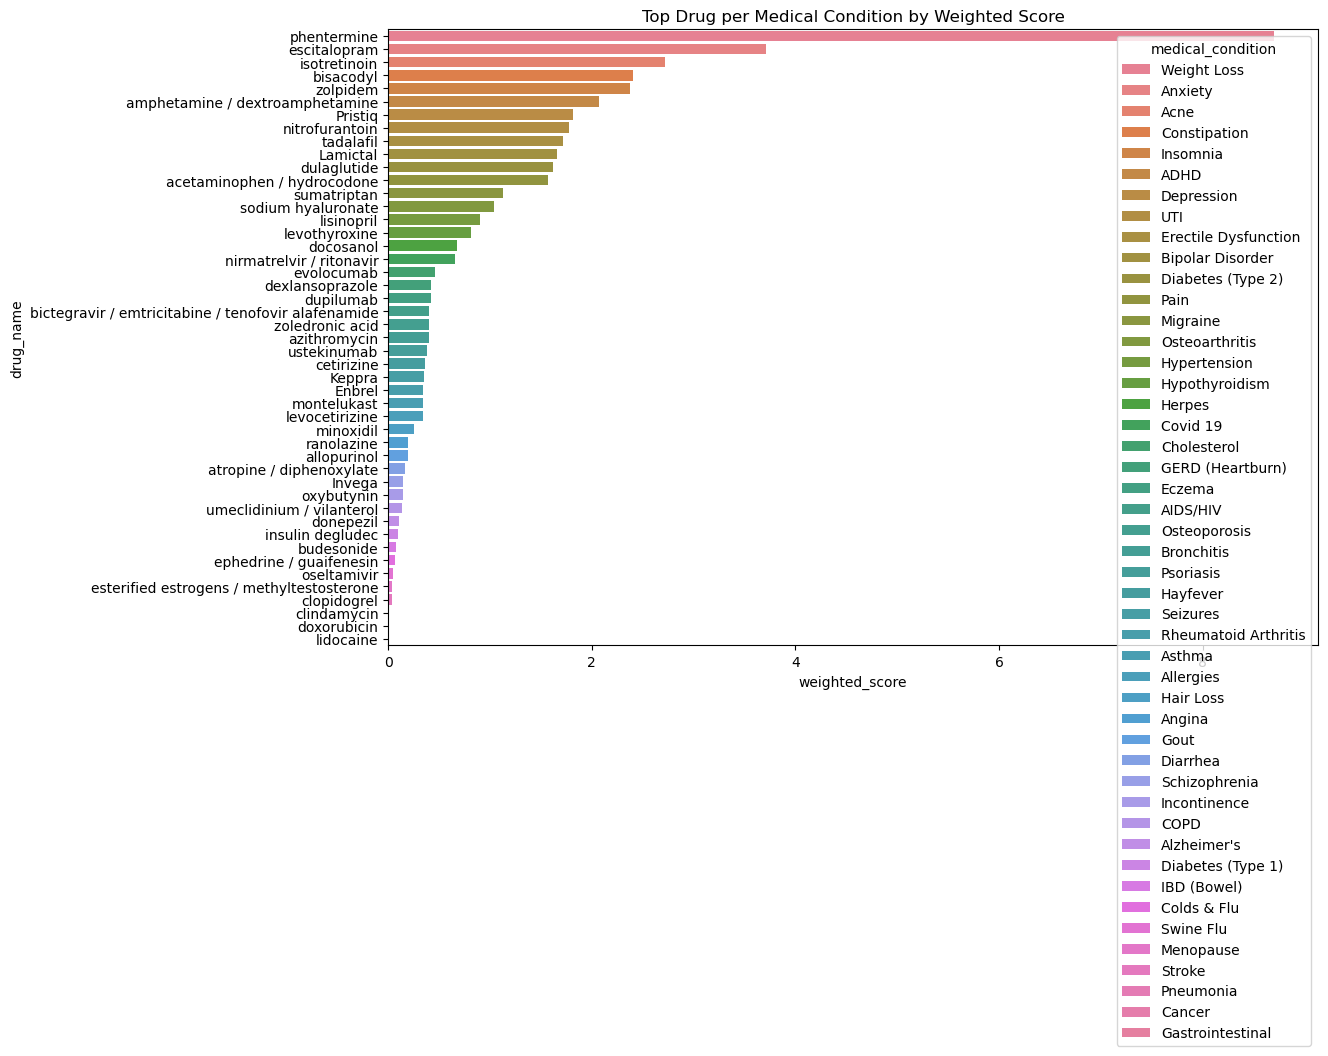

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.barplot(x='weighted_score', y='drug_name', data=top_drugs, hue='medical_condition')
plt.title('Top Drug per Medical Condition by Weighted Score')
plt.show()


In [49]:
def categorize(score):
    if score >= 5:
        return 'High'
    elif score >= 2:
        return 'Medium'
    else:
        return 'Low'

df['tier'] = df['weighted_score'].apply(categorize)
df[['drug_name', 'medical_condition', 'weighted_score', 'tier']]


drug_name medical_condition  weighted_score    tier
2908             phentermine       Weight Loss        8.700000    High
2920  bupropion / naltrexone       Weight Loss        4.528221  Medium
2910                Contrave       Weight Loss        4.361759  Medium
523             escitalopram           Anxiety        3.710089  Medium
2917                 Saxenda       Weight Loss        3.519939  Medium
...                      ...               ...             ...     ...
2427            Duramorph PF              Pain        0.000000     Low
2428              Eha Lotion              Pain        0.000000     Low
2430               Infumorph              Pain        0.000000     Low
2431             Itch Relief              Pain        0.000000     Low
2930           setmelanotide       Weight Loss        0.000000     Low

[2931 rows x 4 columns]

In [50]:
summary = df.groupby('medical_condition')['weighted_score'].agg(['max','mean','min','count'])
summary


max      mean       min  count
medical_condition                                        
ADHD                  2.071984  0.321284  0.000000     55
AIDS/HIV              0.402147  0.040508  0.000000    109
Acne                  2.723926  0.119241  0.000000    238
Allergies             0.341207  0.056727  0.000000     14
Alzheimer's           0.104703  0.016696  0.000000     27
Angina                0.196012  0.007949  0.000000     71
Anxiety               3.710089  0.642037  0.000000     45
Asthma                0.345603  0.046426  0.000000     45
Bipolar Disorder      1.656442  0.351487  0.000000     47
Bronchitis            0.397273  0.027530  0.000000     71
COPD                  0.132106  0.046632  0.000000     23
Cancer                0.006817  0.000562  0.000000     20
Cholesterol           0.455794  0.081193  0.000000     45
Colds & Flu           0.065849  0.002092  0.000000    245
Constipation          2.405044  0.127418  0.000000     60
Covid 19              0.660532  0.046858  0.000000     34
Depression            1.817894  0.335120  0.000000     51
Diabetes (Type 1)     0.099693  0.013553  0.000000     57
Diabetes (Type 2)     1.619905  0.151557  0.000000    104
Diarrhea              0.169052  0.018687  0.000000     38
Eczema                0.418405  0.014073  0.000000    122
Erectile Dysfunction  1.720654  0.489780  0.029141     13
GERD (Heartburn)      0.423177  0.049065  0.000000     77
Gastrointestinal      0.000000  0.000000  0.000000      7
Gout                  0.194206  0.064785  0.000000      9
Hair Loss             0.252897  0.034269  0.000000     11
Hayfever              0.360736  0.029423  0.000000    124
Herpes                0.678868  0.168729  0.003408     10
Hypertension          0.901840  0.046697  0.000000    177
Hypothyroidism        0.813497  0.114568  0.000000     17
IBD (Bowel)           0.080300  0.008329  0.000000     22
Incontinence          0.143763  0.048305  0.000000     19
Insomnia              2.370552  0.182983  0.000000     60
Menopause             0.040763  0.011277  0.000000      7
Migraine              1.124199  0.153449  0.000000     61
Osteoarthritis        1.036878  0.055306  0.000000    129
Osteoporosis          0.399182  0.047188  0.000000     56
Pain                  1.570075  0.061049  0.000000    264
Pneumonia             0.007907  0.000626  0.000000     72
Psoriasis             0.382890  0.024614  0.000000     93
Rheumatoid Arthritis  0.345603  0.080697  0.000000     33
Schizophrenia         0.147239  0.032466  0.000000     20
Seizures              0.353579  0.036562  0.000000     50
Stroke                0.036810  0.013279  0.000000      5
Swine Flu             0.044785  0.019277  0.000000      5
UTI                   1.777914  0.068658  0.000000     46
Weight Loss           8.700000  1.260754  0.000000     23

C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\4021778796.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drugs, x='weighted_score', y='drug_name', palette='viridis')


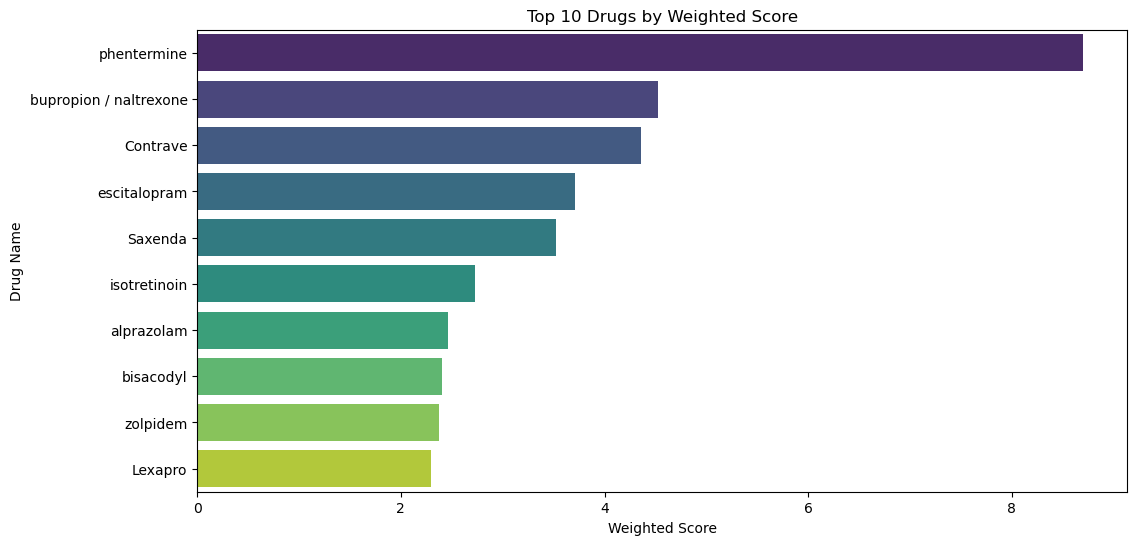

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 drugs by weighted_score
top_drugs = df.sort_values('weighted_score', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_drugs, x='weighted_score', y='drug_name', palette='viridis')
plt.title('Top 10 Drugs by Weighted Score')
plt.xlabel('Weighted Score')
plt.ylabel('Drug Name')
plt.show()


C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\1236738694.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='tier', y='weighted_score', palette='pastel')


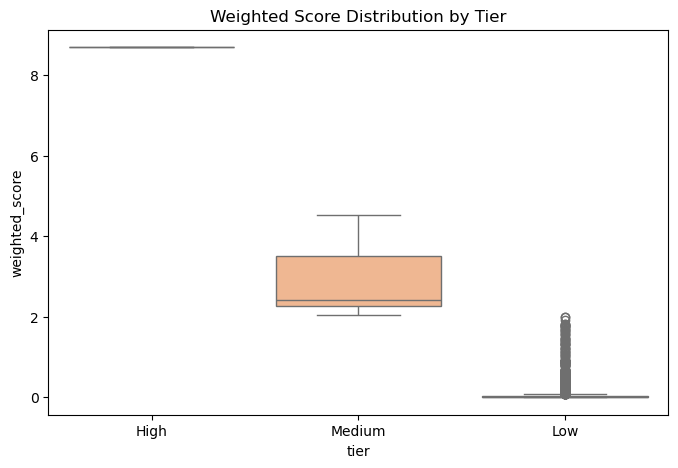

In [52]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='tier', y='weighted_score', palette='pastel')
plt.title('Weighted Score Distribution by Tier')
plt.show()


C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\2520717502.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='coolwarm')


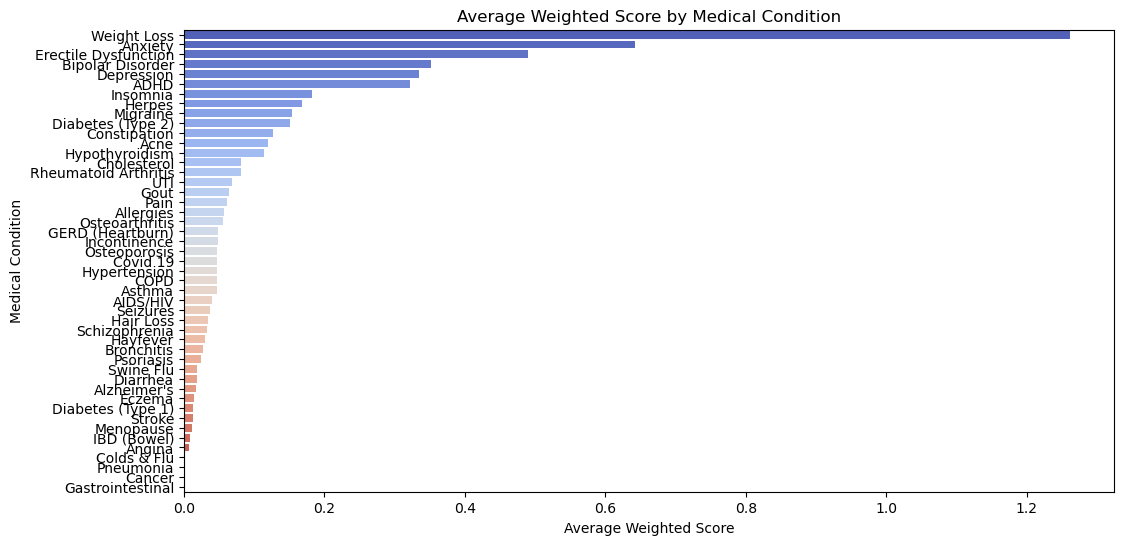

In [53]:
avg_scores = df.groupby('medical_condition')['weighted_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='coolwarm')
plt.title('Average Weighted Score by Medical Condition')
plt.xlabel('Average Weighted Score')
plt.ylabel('Medical Condition')
plt.show()


C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\2752144546.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='tier', palette='Set2')


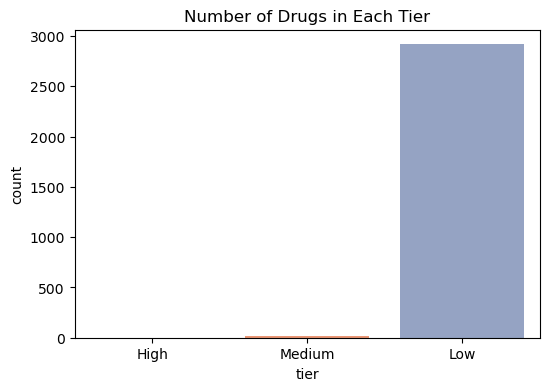

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='tier', palette='Set2')
plt.title('Number of Drugs in Each Tier')
plt.show()


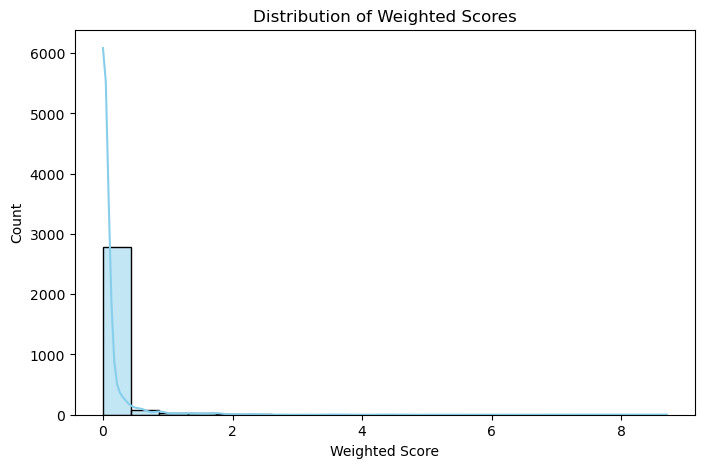

C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\1139345431.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tier', y='weighted_score', data=df, palette='pastel')


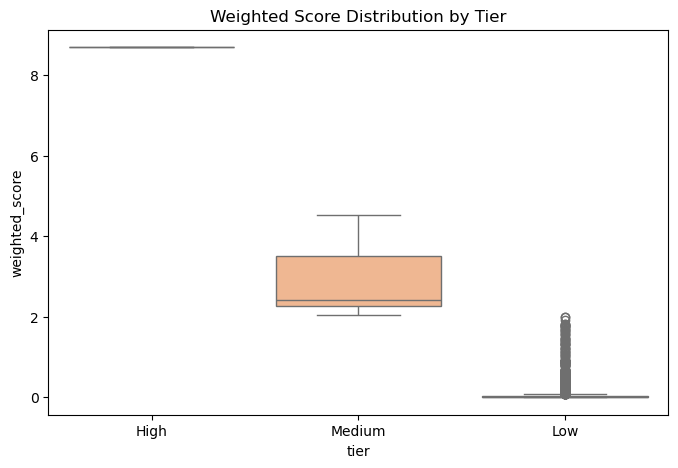

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Weighted score distribution
plt.figure(figsize=(8,5))
sns.histplot(df['weighted_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Weighted Scores')
plt.xlabel('Weighted Score')
plt.ylabel('Count')
plt.show()

# Boxplot by tier
plt.figure(figsize=(8,5))
sns.boxplot(x='tier', y='weighted_score', data=df, palette='pastel')
plt.title('Weighted Score Distribution by Tier')
plt.show()


C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\1066152376.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='coolwarm')


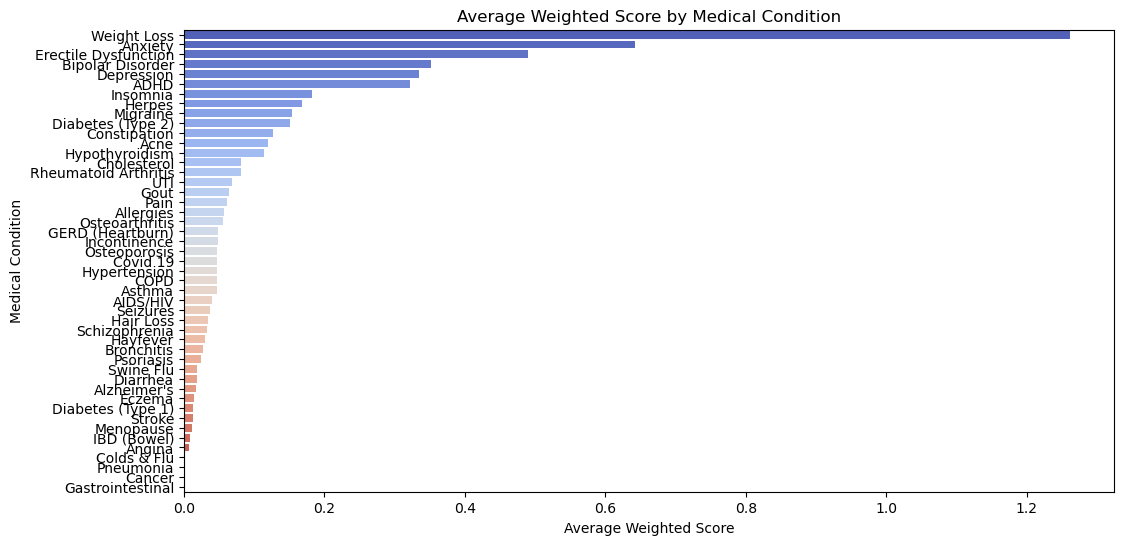

C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\1066152376.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='tier', data=df, palette='Set2')


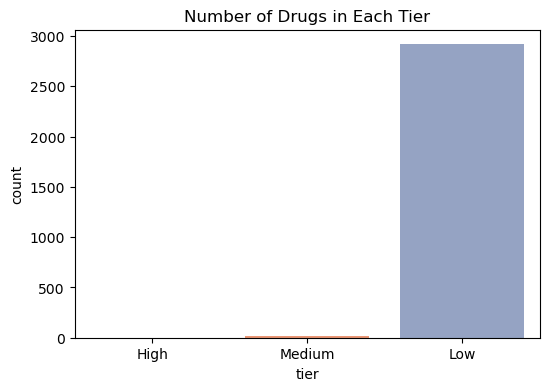

In [56]:
# Average weighted score per medical condition
avg_scores = df.groupby('medical_condition')['weighted_score'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='coolwarm')
plt.title('Average Weighted Score by Medical Condition')
plt.xlabel('Average Weighted Score')
plt.ylabel('Medical Condition')
plt.show()

# Count of drugs per tier
plt.figure(figsize=(6,4))
sns.countplot(x='tier', data=df, palette='Set2')
plt.title('Number of Drugs in Each Tier')
plt.show()


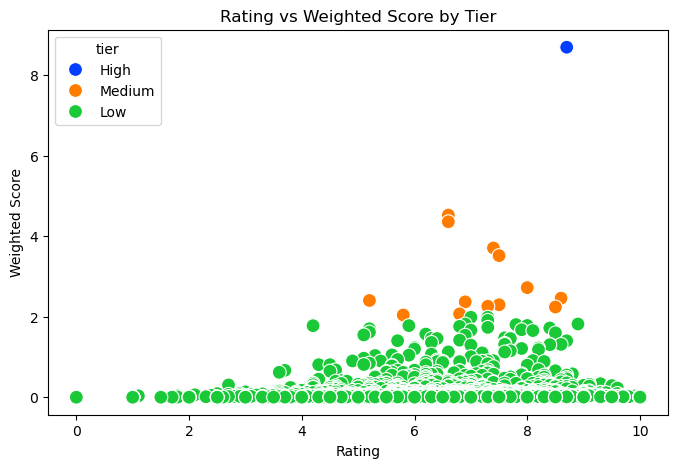

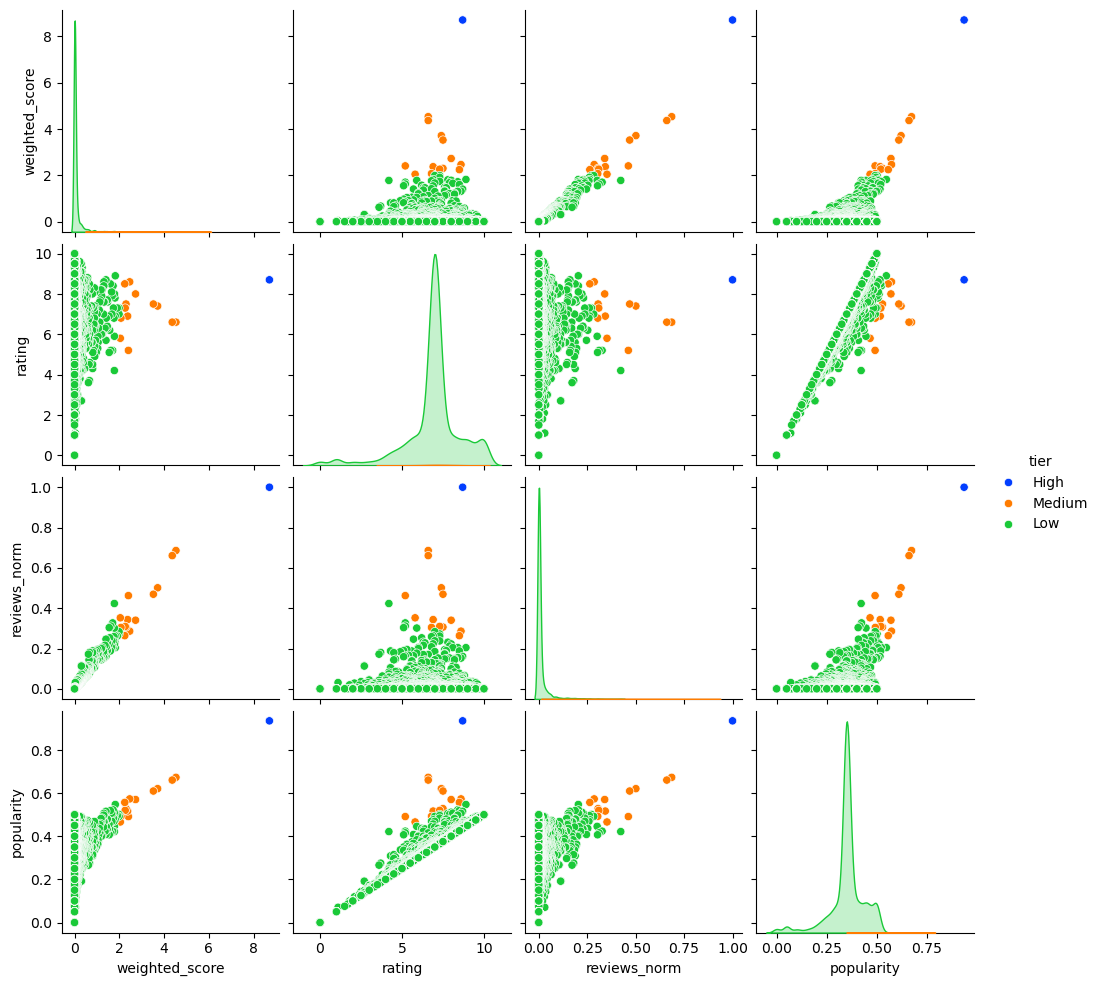

In [57]:
# Scatter plot with tier hue
plt.figure(figsize=(8,5))
sns.scatterplot(x='rating', y='weighted_score', hue='tier', data=df, palette='bright', s=100)
plt.title('Rating vs Weighted Score by Tier')
plt.xlabel('Rating')
plt.ylabel('Weighted Score')
plt.show()

# Pairplot (multi-variable relationships)
sns.pairplot(df[['weighted_score','rating','reviews_norm','popularity','tier']], hue='tier', palette='bright')
plt.show()


C:\Users\Pallavi M\AppData\Local\Temp\ipykernel_15444\2971180704.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_score', y='drug_name', data=top_drugs, palette='viridis')


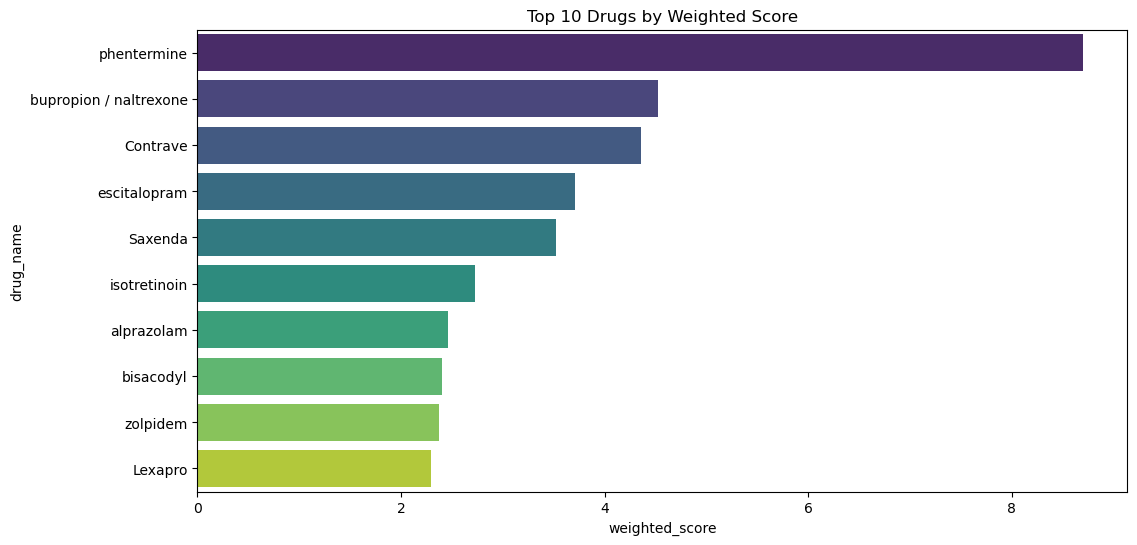

In [59]:
# Top 10 drugs by weighted score
top_drugs = df.sort_values('weighted_score', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='weighted_score', y='drug_name', data=top_drugs, palette='viridis')
plt.title('Top 10 Drugs by Weighted Score')
plt.show()


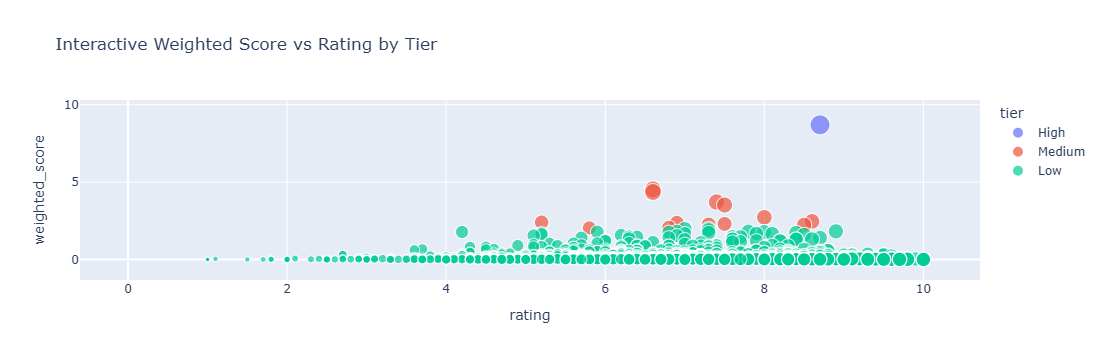

In [60]:
import plotly.express as px

fig = px.scatter(df, x='rating', y='weighted_score', color='tier',
                 hover_data=['drug_name','medical_condition'], size='popularity',
                 title='Interactive Weighted Score vs Rating by Tier')
fig.show()


In [ ]:
!python create_model_files.py

In [ ]:
!streamlit run drug_dashboard.py
